### Naive vs Marla

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import sys
import json
from datetime import datetime
from collections import defaultdict
sys.path.append("../traffic_generator")
sys.path.append("../interference_injection")

In [ ]:
# Path to local CSV folder
csv_folder = "/home/george/Workshop/Interference/Results/traffic_generator_csvs"
naive_logs_folder = "/home/george/Workshop/Interference/Results/naive_logs"
marla_logs_folder = "/home/george/Workshop/Interference/Results/marla_logs"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))


In [ ]:
def plot_metric_over_time(csv_filenames, metric="P99_Latency", folder_path="./traffic_generator_csvs"):
    """
    Plots the selected metric over time for selected CSV files,
    keeping only values below 20 for P99_Latency.
    Also prints the average of the metric for each file,
    and how much they differ in percentage.

    Args:
        csv_filenames (list): List of CSV filenames.
        metric (str): The metric column to plot (default: "P99_Latency").
        folder_path (str): Folder where the CSV files are stored.
    """
    plt.figure(figsize=(12, 6))
    averages = {}

    for filename in csv_filenames:
        full_path = os.path.join(folder_path, filename)
        if not os.path.exists(full_path):
            print(f"Warning: File not found: {full_path}")
            continue
        
        df = pd.read_csv(full_path)
        df['Minute'] = pd.to_numeric(df['Minute'], errors='coerce')
        df[metric] = pd.to_numeric(df[metric], errors='coerce')
        df = df[df[metric] < 20]  # Filter outliers if metric is latency
        
        label = filename.replace(".csv", "")
        averages[label] = df[metric].mean()

        plt.plot(df['Minute'], df[metric], marker='o', linewidth=2, label=label)

    plt.title(f"{metric.replace('_', ' ')} Over Time per Experiment")
    plt.xlabel("Minute")
    plt.ylabel(metric.replace("_", " ") + " (ms)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(range(1, 31))
    plt.show()

    # Print averages and % difference
    print("\n=== AVERAGE METRIC VALUES ===")
    for label, avg in averages.items():
        print(f"{label}: {avg:.3f}")

    if len(averages) == 2:
        labels = list(averages.keys())
        val1, val2 = averages[labels[0]], averages[labels[1]]
        percent_diff = abs(val1 - val2) / ((val1 + val2) / 2) * 100
        print(f"\nDifference between {labels[0]} and {labels[1]}: {percent_diff:.2f}%")
    elif len(averages) > 2:
        print("\nPercentage differences between all files:")
        labels = list(averages.keys())
        for i in range(len(labels)):
            for j in range(i+1, len(labels)):
                a, b = labels[i], labels[j]
                v1, v2 = averages[a], averages[b]
                percent_diff = abs(v1 - v2) / ((v1 + v2) / 2) * 100
                print(f"{a} vs {b}: {percent_diff:.2f}%")


In [36]:
def get_replica_distribution_df(test_id, threshold_seconds=30):
    from datetime import timedelta

    # === Resolve file paths based on test_id ===
    schedule_path = f"./traffic_generator_csvs/performance_{test_id}.csv"
    if "naive" in test_id:
        distribution_path = f"./naive_logs/{test_id}.jsonl"
    elif "marla" in test_id:
        distribution_path = f"./marla_logs/{test_id}.jsonl"
    else:
        raise ValueError("test_id must contain 'naive' or 'marla'")

    if not os.path.exists(schedule_path):
        raise FileNotFoundError(f"Missing: {schedule_path}")
    if not os.path.exists(distribution_path):
        raise FileNotFoundError(f"Missing: {distribution_path}")

    # === Step 1: Load timestamp → minute map from CSV ===
    perf_df = pd.read_csv(schedule_path)
    perf_df["Time"] = pd.to_datetime(perf_df["Time"].str.replace("Z", "+00:00"), utc=True)

    timestamp_to_minute = {
        row["Time"].to_pydatetime(): int(row["Minute"])
        for _, row in perf_df.iterrows()
    }
    sorted_ts = sorted(timestamp_to_minute.keys())

    # === Step 2: Load distribution JSONL ===
    with open(distribution_path, "r") as f:
        distribution = [json.loads(line) for line in f]

    minute_node_counts = defaultdict(lambda: defaultdict(int))
    all_nodes = set()

    for entry in distribution:
        dist_ts = datetime.fromisoformat(entry["timestamp"].replace("Z", "+00:00"))

        # Look for an exact or close match in known schedule timestamps
        matched_minute = None
        for sched_ts in sorted_ts:
            if abs((dist_ts - sched_ts).total_seconds()) <= threshold_seconds:
                matched_minute = timestamp_to_minute[sched_ts]
                break

        if matched_minute is None:
            continue  # Skip entries that are not within threshold of any minute

        # Determine the correct key for replica counts
        dist_key = None
        for key in ["actual_distribution", "replica_plan", "replica_distribution"]:
            if key in entry:
                dist_key = key
                break
        if dist_key is None:
            continue

        dist = entry[dist_key]
        all_nodes.update(dist.keys())

        for node, count in dist.items():
            minute_node_counts[matched_minute][node] += count

    # === Build DataFrame ===
    all_minutes = sorted(minute_node_counts.keys())
    data = []
    for minute in all_minutes:
        row = {"Minute": minute}
        for node in all_nodes:
            row[node] = minute_node_counts[minute].get(node, 0)
        data.append(row)

    return pd.DataFrame(data).sort_values("Minute")


In [37]:
from matplotlib.ticker import MaxNLocator

def plot_replica_distribution_over_time(test_id):
    df = get_replica_distribution_df(test_id)
    if df.empty:
        print("No data available to plot.")
        return

    node_columns = [col for col in df.columns if col != "Minute"]

    fig, axes = plt.subplots(
        nrows=len(node_columns),
        ncols=1,
        figsize=(12, 4 * len(node_columns)),
        sharex=True
    )

    if len(node_columns) == 1:
        axes = [axes]  # Make iterable if only one subplot

    for ax, node in zip(axes, node_columns):
        ax.plot(df["Minute"], df[node], color="tab:blue", marker='o', linewidth=2)
        ax.set_ylabel("Replicas")
        ax.set_title(f"{node}")
        ax.grid(True)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # 👈 Force integer ticks

    axes[-1].set_xlabel("Minute")
    fig.suptitle(f"Replica Distribution Over Time — {test_id}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


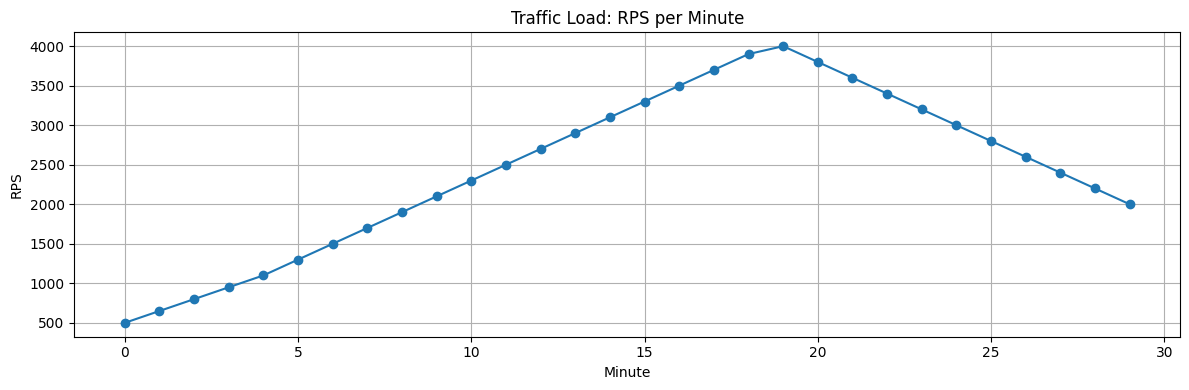

In [38]:
from config import RPS_30MIN_GRADUAL_WIDE

def plot_rps_schedule(rps_schedule, title="Traffic Load: RPS per Minute"):
    plt.figure(figsize=(12, 4))
    plt.plot(range(len(rps_schedule)), rps_schedule, marker='o')
    plt.xlabel("Minute")
    plt.ylabel("RPS")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_rps_schedule(RPS_30MIN_GRADUAL_WIDE)


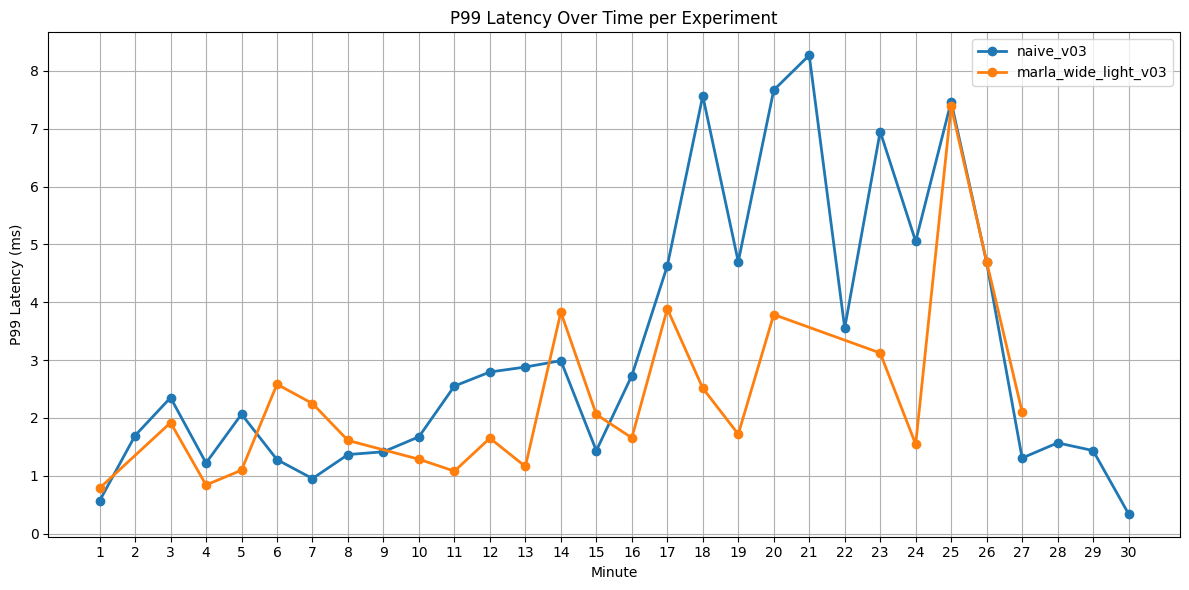


=== AVERAGE METRIC VALUES ===
naive_v03: 3.172
marla_wide_light_v03: 2.373

Difference between naive_v03 and marla_wide_light_v03: 28.83%


In [39]:
#plot_metric_over_time(["naive_v01.csv", "marla_v01.csv"])
plot_metric_over_time(["naive_v03.csv", "marla_wide_light_v03.csv"], metric="P99_Latency")
#plot_metric_over_time(["WIDE_lightLong_naive_v01.csv","WIDE_lightLong_marla_v01.csv"]) 


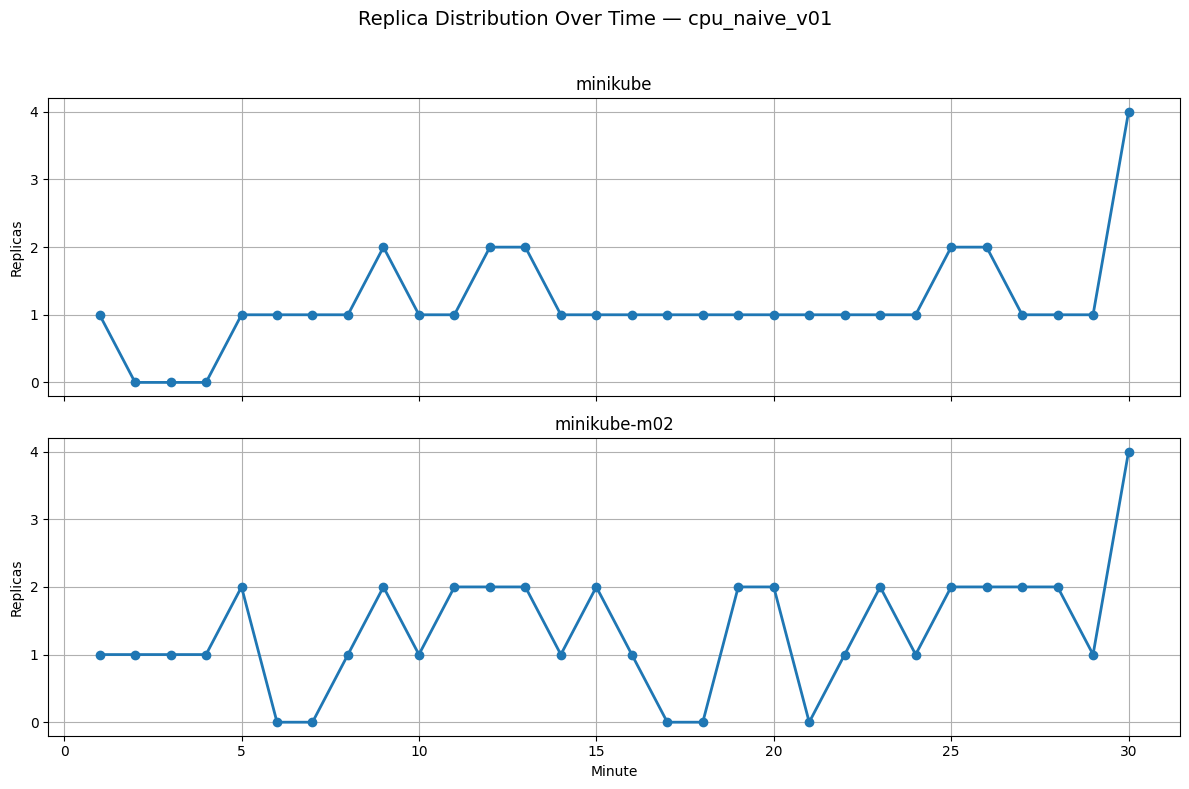

In [40]:
plot_replica_distribution_over_time("cpu_naive_v01")